# Soft Actor-Critic
**Stabiliztion of an orbitting particle**

### Import libraries

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
import matplotlib.animation as animation

# import local libraries
from environments.orbit import Orbital_SDI
from src.SoftActorCritic.main import SACAgent

## Live plot particle

In [2]:
theta_plot = np.linspace(-np.pi, np.pi, 100)
x_plot = np.cos(theta_plot)
y_plot = np.sin(theta_plot)
def plot(x, y, it):
    clear_output(True)
    fig, ax = plt.subplots()
    ax.plot(x_plot, y_plot, c='r')
    ax.scatter(x, y, s=100)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_title(f'iteration: {it:.0f}')
    plt.show()

In [3]:
# Animated plot as video
def anim_plot(X, Y, title=None, filename='Orbitting_particle'):
    n_iter = len(X)
    
    # initializing a figure
    fig, ax = plt.subplots()
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])

    # initializing a line variable
    ax.plot(x_plot, y_plot, c='r')
    point, = ax.plot([],[], marker="o", markersize=8)

    def animate(t):
        x_t = X[t]
        y_t = Y[t]
        point.set_data(x_t, y_t)
        point.set_color('blue')
        return point,


    anim = animation.FuncAnimation(fig, animate, frames=n_iter, interval=20, blit=True)
    fig.suptitle(title, fontsize=14)

    # save animation
    writervideo = animation.FFMpegWriter(fps=20)
    anim.save(f'{filename}.mp4', writer=writervideo)
    plt.close()

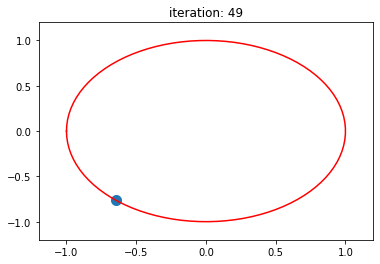

In [4]:
env = Spherical_SDI()
#env.state = jnp.array([0, 0])

control = -1
for it in range(50):
    observation, reward, done, _ = env.step(control)
    x, y, w =  observation
    plot(x, y, it)


## Initialization

In [4]:
seed = 0
np.random.seed(seed)
key = jrandom.PRNGKey(seed)

env = Orbital_SDI()

In [5]:
# parameters
num_frames = 8000 #50000
memory_size = 100000
batch_size = 128
initial_random_steps = 1000

obs_size = 3
ctrl_size = 1

agent = SACAgent(
    env, memory_size, key, initial_random_steps=initial_random_steps, obs_size=obs_size, ctrl_size=ctrl_size
)

## Training

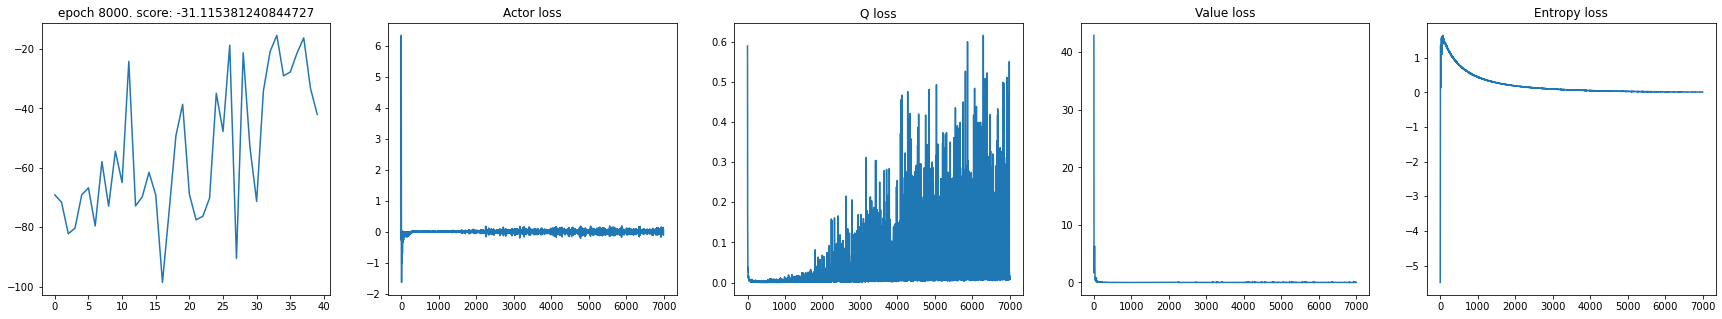

In [6]:
agent.train(num_frames, key, plotting_interval=200)

## Results

### Networks surface plots

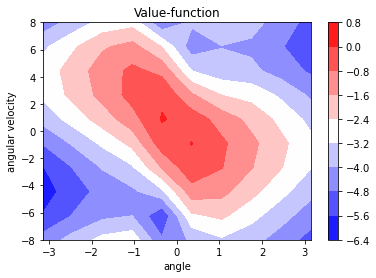

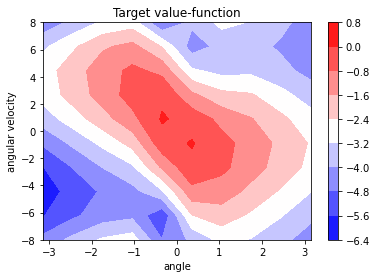

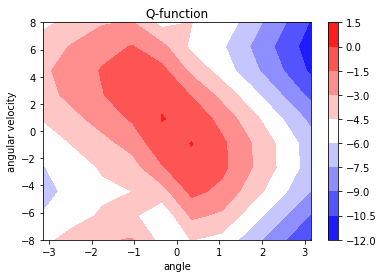

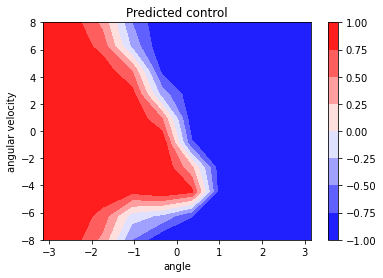

In [7]:
# Value and policy functions

key = jrandom.PRNGKey(0)

N = 10
x_space = np.linspace(-np.pi, np.pi, N)
v_space = np.linspace(-8, 8, N)
xv, vv = np.meshgrid(x_space, v_space)
Q = np.zeros((N, N))
V = np.zeros((N, N))
V_target = np.zeros((N, N))
U = np.zeros((N, N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([np.cos(x), np.sin(x), v])
    control = jnp.array([0])
    V[i, j] = agent.VF(state)
    V_target[i, j] = agent.VF_target(state)
    Q[i, j] = agent.q_min(state, control)
    key, _ = jrandom.split(key)
    U[i, j], _ = agent.actor(state, key, deterministic=True)

fig, ax = plt.subplots()
plt.contourf(xv, vv, V, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, V_target, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Target value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, Q, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Q-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, U, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Predicted control')
plt.show()




### Test trajectory

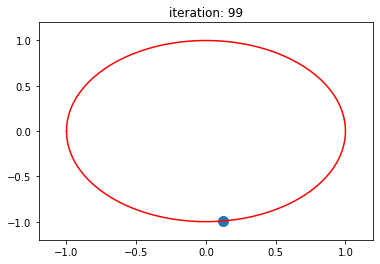

In [8]:
key = jrandom.PRNGKey(1)
env = Spherical_SDI()
#env.state = jnp.array([0, 0])

observation = env._get_obs(key)
for it in range(100):
    key, subkey = jrandom.split(key)
    control = agent.get_control(observation, key)
    observation, reward, done, _ = env.step(control, key=subkey)
    x, y, w = observation
    plot(y, -x, it)


In [17]:
key = jrandom.PRNGKey(0)
N = 200

env = Spherical_SDI(end_time=20)

X_data = np.zeros(N)
Y_data = np.zeros(N)

observation = env._get_obs(key)
for it in range(N):
    key, subkey = jrandom.split(key)
    control = agent.get_control(observation, key)
    observation, reward, done, _ = env.step(control, key=subkey)
    x, y, w = observation

    X_data[it] = x
    Y_data[it] = y
    
    if done:
        X_data = X_data[:it]
        Y_data = Y_data[:it]
        break



In [20]:
#anim_plot(Y_data, -X_data, title='Controlled orbiting particle')